In [1]:
import xgboost
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import random

In [2]:
def getInputOutputFolder(fileFlag=None):
    f  = open("data_file.txt", "r")
    i  = 0
    for l in f.readlines():
        if fileFlag<32:
            if i==fileFlag:
                foldName = l[:-1]
        if fileFlag==32:
            if i==fileFlag:
                foldName = l
        
        i = i+1
    f.close()
    dataNameSplit = foldName.split("/")
    inputFileName  = '../../data/'+ dataNameSplit[1]+'/inputs.csv'
    outputFileName = '../../data/'+ dataNameSplit[1]+'/outputs.csv'
    foldName       = '../../'+foldName
    return inputFileName,outputFileName,foldName,dataNameSplit[1]

In [3]:
# Input the File Number
# Not Working - 17,18,19,20,21,22,23,24,25
fileFlag = 0
inputFileName,outputFileName,foldName,dataName = getInputOutputFolder(fileFlag)
print(inputFileName)
print(outputFileName)
print(foldName)
print(dataName)

../../data/ATAC_JV_adipose/inputs.csv
../../data/ATAC_JV_adipose/outputs.csv
../../data/ATAC_JV_adipose/cv/equal_labels/folds.csv
ATAC_JV_adipose


In [4]:
input      = pd.read_csv(inputFileName)
label      = pd.read_csv(outputFileName)
folds      = pd.read_csv(foldName)
folds_iter = folds['fold'].unique()
print(folds_iter)
input.replace([np.inf, -np.inf], np.nan,inplace=True)

[2 4 1 3]


In [5]:
colnames       = input.columns.values
colnamesSeries = input.isna().sum()
nullColnames   = list(colnamesSeries.index[colnamesSeries>0].values)
nullColnames.append('sequenceID')
colnames       = [x for x in colnames if x not in nullColnames]

In [6]:
def chart_creation_xgboost(res,chart_title,chart_name):
    
    min_valid = round(np.min(res['test']['normal,1.0']),4)
    min_train = round(np.min(res['train']['normal,1.0']),4)
    min_iter  = round(np.nanargmin(res['test']['normal,1.0']),0)

    textstr = '\n'.join((
                    'Min Train = %.2f' % (min_train, ),
                    'Min Valid = %.2f' % (min_valid, ),
                    'Min Iter  = %.2f' % (min_iter, )))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5,edgecolor="black")
    
    fig,ax1       = plt.subplots()
    ax2           = ax1.twinx()

    ln1 = ax1.plot(res['train']['normal,1.0'],color='blue',label='Training')
    ln2 = ax2.plot(res['test']['normal,1.0'],color='orange',label='Validation')
    
    lns = ln1 + ln2
    
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc='lower left',fancybox='round', facecolor='wheat',fontsize=8)
    
    ax1.set_xlabel("Number of Iterations(Trees)")
    ax1.set_ylabel("Training Negative Likelihood(Loss)")
    ax2.set_ylabel("Validation Negative Likelihood(Loss)")
    ax2.text(0.7, 0.90, textstr, transform=ax1.transAxes, fontsize=8,
        verticalalignment='top', bbox=props)
    plt.title(chart_title)
    plt.show()
    fig.savefig(chart_name)
    
def generate_result(X,y_lower,y_higher,params,X_val=None,y_lower_val=None,y_higher_val=None):
    
    res    = {}
    dtrain = xgboost.DMatrix(X)
    dtrain.set_float_info("label_lower_bound",y_lower)
    dtrain.set_float_info("label_upper_bound",y_higher)
    
    dtest  = xgboost.DMatrix(X_val)
    dtest.set_float_info("label_lower_bound",y_lower_val)
    dtest.set_float_info("label_upper_bound",y_higher_val)
    
    bst    = xgboost.train(params,dtrain,num_boost_round=100,evals=[(dtrain,"train"),(dtest,"test")],evals_result=res)
    return res

In [7]:
for i in folds_iter:
    
    test_fold    = i
    test_id      = folds[folds["fold"]==i]['sequenceID']
    train_id     = folds[folds["fold"]!=i]['sequenceID']
    nullId       = label[(label['min.log.lambda']==-float('inf'))&(label['max.log.lambda']==float('inf'))]['sequenceID']
    X            = input[input['sequenceID'].isin(train_id)&(~input['sequenceID'].isin(nullId))]
    X_val        = input[input['sequenceID'].isin(test_id)&(~input['sequenceID'].isin(nullId))]
    
    X            = X[colnames]
    X_val        = X_val[colnames]
    y_label      = label[label['sequenceID'].isin(train_id)&(~label['sequenceID'].isin(nullId))]
    y_label_test = label[label['sequenceID'].isin(test_id)&(~label['sequenceID'].isin(nullId))]
    
    y_lower      = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['min.log.lambda'])))
    y_higher     = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label['max.log.lambda'])))
    y_lower_val  = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['min.log.lambda'])))
    y_higher_val = np.array(list(map(lambda x: x if x == float('inf') or x == -float('inf') else np.exp(x),y_label_test['max.log.lambda'])))
    
    data_name    = dataName
    title        = 'Loss=LogLoss,Data='+data_name+' Test Fold='+str(test_fold)
    file_name    = title+'.png'
    
    params = {'learning_rate':0.1, 'aft_noise_distribution' : 'normal', 'aft_sigma': 1.0,'eval_metric':'aft-nloglik@normal,1.0','objective':"aft:survival"}
    bst    = generate_result(X,y_lower,y_higher,params,X_val,y_lower_val,y_higher_val)
    chart_creation_xgboost(bst,title,file_name)

[0]	train-normal,1.0:nan	test-normal,1.0:nan
[1]	train-normal,1.0:nan	test-normal,1.0:nan
[2]	train-normal,1.0:nan	test-normal,1.0:nan
[3]	train-normal,1.0:nan	test-normal,1.0:nan
[4]	train-normal,1.0:nan	test-normal,1.0:nan
[5]	train-normal,1.0:nan	test-normal,1.0:nan
[6]	train-normal,1.0:nan	test-normal,1.0:nan
[7]	train-normal,1.0:nan	test-normal,1.0:nan
[8]	train-normal,1.0:nan	test-normal,1.0:nan
[9]	train-normal,1.0:nan	test-normal,1.0:nan
[10]	train-normal,1.0:nan	test-normal,1.0:nan
[11]	train-normal,1.0:nan	test-normal,1.0:nan
[12]	train-normal,1.0:nan	test-normal,1.0:nan
[13]	train-normal,1.0:nan	test-normal,1.0:nan
[14]	train-normal,1.0:nan	test-normal,1.0:nan
[15]	train-normal,1.0:nan	test-normal,1.0:nan
[16]	train-normal,1.0:nan	test-normal,1.0:nan
[17]	train-normal,1.0:nan	test-normal,1.0:nan
[18]	train-normal,1.0:nan	test-normal,1.0:nan
[19]	train-normal,1.0:nan	test-normal,1.0:nan
[20]	train-normal,1.0:nan	test-normal,1.0:nan
[21]	train-normal,1.0:nan	test-normal,1.0:na

ValueError: All-NaN slice encountered

In [11]:
data      = pd.read_csv('simulate_survival.csv')
rows,cols = data.shape[0],data.shape[1]
list1  =  list(np.arange(rows))
sample =  random.sample(list1, 800)

In [12]:
train = data[data.index.isin(sample)]
test  = data[~data.index.isin(sample)]

In [13]:
X            = train[['x1','x2','x3']]
X_val        = test[['x1','x2','x3']]
y_lower      = train['left']
y_lower_val  = test['left']
y_higher     = train['right']
y_higher_val = test['right']

[0]	train-normal,1.0:634.816	test-normal,1.0:196.334
[1]	train-normal,1.0:364.906	test-normal,1.0:140.4
[2]	train-normal,1.0:310.165	test-normal,1.0:122.936
[3]	train-normal,1.0:295.065	test-normal,1.0:120.184
[4]	train-normal,1.0:291.002	test-normal,1.0:118.94
[5]	train-normal,1.0:288.286	test-normal,1.0:118.076
[6]	train-normal,1.0:286.243	test-normal,1.0:118.917
[7]	train-normal,1.0:285.441	test-normal,1.0:118.63
[8]	train-normal,1.0:284.555	test-normal,1.0:118.509
[9]	train-normal,1.0:283.808	test-normal,1.0:118.172
[10]	train-normal,1.0:283.662	test-normal,1.0:118.567
[11]	train-normal,1.0:283.379	test-normal,1.0:118.012
[12]	train-normal,1.0:283.225	test-normal,1.0:118.317
[13]	train-normal,1.0:283.121	test-normal,1.0:118.541
[14]	train-normal,1.0:282.996	test-normal,1.0:118.692
[15]	train-normal,1.0:282.925	test-normal,1.0:118.632
[16]	train-normal,1.0:282.867	test-normal,1.0:119.135
[17]	train-normal,1.0:282.807	test-normal,1.0:119.073
[18]	train-normal,1.0:282.742	test-normal,

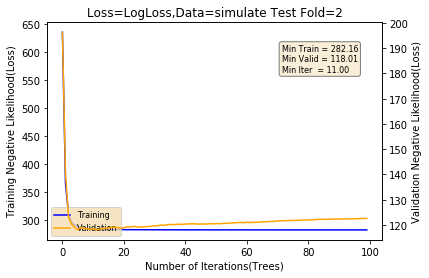

In [14]:
dataName    = 'simulate'
data_name   = dataName
title       = 'Loss=LogLoss,Data='+data_name+' Test Fold='+str(test_fold)
file_name   = title+'.png'
    
params = {'learning_rate':1, 'aft_noise_distribution' : 'normal', 'aft_sigma': 1.0,'eval_metric':'aft-nloglik@normal,1.0','objective':"aft:survival"}
bst    = generate_result(X,y_lower,y_higher,params,X_val,y_lower_val,y_higher_val)
chart_creation_xgboost(bst,title,file_name)